# Import Required Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import geopandas as gpd
from shapely.geometry import Polygon
import geodatasets
import matplotlib.ticker as mticker 
from matplotlib.colors import ListedColormap
from loguru import logger
import sys

In [3]:
import rasterio
import rasterio.mask
import rioxarray as rxr
from matplotlib.dates import MonthLocator, DateFormatter, AutoDateLocator, ConciseDateFormatter
from matplotlib import colormaps
from pathlib import Path
import re
from tqdm.notebook import tqdm

In [4]:
import xarray as xr

In [5]:
import copernicusmarine

# Download Data from Copernicus Marine Service

The analysis used data from the Arctic Ocean Sea Ice Reanalysis (E.U. Copernicus Marine Service Information, CMEMS, Marine Data Store, DOI: 10.48670/mds-00336), as well as a guideline provided by Chiara Phillips.

In [23]:
copernicusmarine.subset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2023-01-01T00:00:00",
  end_datetime="2023-12-01T00:00:00",
  output_directory="data",
  file_format="zarr"
)

INFO - 2025-05-13T08:38:28Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


INFO - 2025-05-13T08:38:41Z - Selected dataset version: "202411"
INFO - 2025-05-13T08:38:41Z - Selected dataset part: "default"
INFO - 2025-05-13T08:38:49Z - Starting download. Please wait...


  0%|          | 0/871 [00:00<?, ?it/s]

INFO - 2025-05-13T08:41:48Z - Successfully downloaded to data\cmems_mod_arc_phy_my_nextsim_P1M-m_siconc_180.00W-179.97E_49.98N-90.03N_2023-01-01-2023-12-01.zarr


ResponseSubset(file_path=WindowsPath('data/cmems_mod_arc_phy_my_nextsim_P1M-m_siconc_180.00W-179.97E_49.98N-90.03N_2023-01-01-2023-12-01.zarr'), output_directory=WindowsPath('data'), filename='cmems_mod_arc_phy_my_nextsim_P1M-m_siconc_180.00W-179.97E_49.98N-90.03N_2023-01-01-2023-12-01.zarr', file_size=1468.5931526717557, data_transfer_size=1728.9497404580152, variables=['siconc'], coordinates_extent=[GeographicalExtent(minimum=-180.0, maximum=179.97000000001367, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=49.98, maximum=90.03000000000151, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2023-01-01T00:00:00+00:00', maximum='2023-12-01T00:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

# 1. Creating Latitude Bands for Spatial Analysis

We will create 10-degree latitude bands from the Equator (0°) to the North Pole (90°). Each band represents a horizontal slice of the globe.

The longitude range is set to -180° to 180°, covering the entire globe.

In [24]:
# Define the range of latitude bands (Equator to North Pole)
latitude_bands = [(lat, lat + 10) for lat in range(0, 90, 10)]  # From 0° to 90° in 10° steps

# Define longitude extent (Global)
lon_min, lon_max = -180, 180

Each latitude band is represented as a rectangular polygon spanning the full longitude range. These polygons are stored along with their corresponding latitude range labels.

In [25]:
# List to store polygons and attributes
polygons = []
labels = []

# Generate polygons for each latitude band
for lat_min, lat_max in latitude_bands:
    polygon = Polygon([
        (lon_min, lat_min), (lon_max, lat_min),
        (lon_max, lat_max), (lon_min, lat_max),
        (lon_min, lat_min)  # Closing the polygon
    ])
    polygons.append(polygon)
    labels.append(f"{lat_min}° to {lat_max}°")

### Creating a geospatial dataframe

The dataset includes:

* A "Latitude_Range" column labeling each band (e.g., "0° to 10°", "10° to 20°", etc.).
* A geometry column containing the corresponding polygons.
* The coordinate reference system (CRS) set to EPSG:4326 (WGS84), the standard for geographic data

In [26]:
gdf = gpd.GeoDataFrame(
        {"Latitude_Range": labels},  # Attribute data
        geometry=polygons,           # Polygon shapes
        crs="EPSG:4326"              # Set coordinate system
)

# Save as GeoJSON
geojson_name = "data/latitude_bands_global.geojson"

gdf.to_file(geojson_name, driver="GeoJSON")

### Visualize the Latitude Bands

In [27]:
# Load the landmass layer from geodatasets
land = gpd.read_file(geodatasets.get_path("naturalearth.land"))

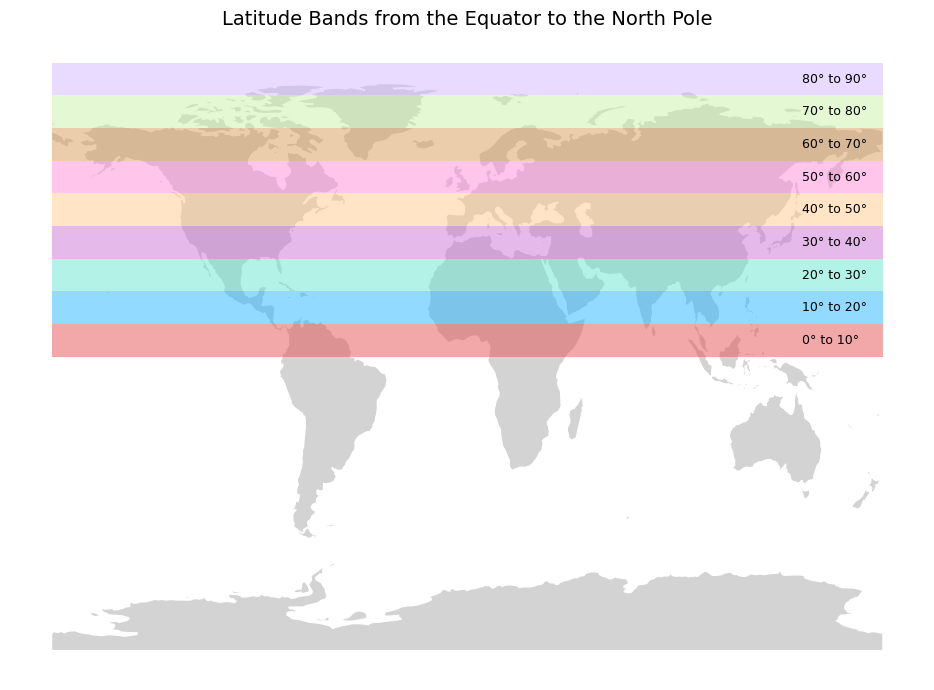

In [28]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot land background
land.plot(ax=ax, color="lightgray", edgecolor="white")

# Configure color palette
esri_beaded_pastel_colors = [
"#e65154", "#26b6ff", "#67e6d1", "#cd76d6", "#ffca8c",
"#ff8cd9", "#d99d5b", "#c8f2a9", "#d4b8ff"
]
    
# Plot latitude bands with transparency
gdf.plot(
    column="Latitude_Range",
    cmap=ListedColormap(esri_beaded_pastel_colors),
    edgecolor="none",
    alpha=0.5,
    linewidth=0.8,
    ax=ax,
    legend=False
)

# Add labels
for idx, row in gdf.iterrows():
    minx, miny, maxx, maxy = row.geometry.bounds
    label_x = 145
    label_y = (miny + maxy) / 2

    ax.text(
        label_x, label_y,
        row["Latitude_Range"],
        ha="left",
        va="center",
        fontsize=9,
        color="black"
    )

# Title
ax.set_title("Latitude Bands from the Equator to the North Pole", fontsize=14)
ax.set_axis_off()
plt.tight_layout() 
plt.show()

# 2. Load Ocean Vector (GOaS)

The Global Oceans and Seas (GOaS) dataset is used to identify and distinguish specific oceanic and sea regions. In my case, it helps define the geographic boundaries of the Arctic Ocean and its subregions. This is essential for spatial filtering, regional analysis, and accurate visualization of the sea ice reanalysis data.

<a href="https://www.marineregions.org/download_file.php?name=GOaS_v1_20211214_gpkg.zip">Download GOaS_v1_20211214_gpkg.zip</a>

In [29]:
goas_vector = gpd.read_file("/Users/Liza/Documents/my_data/environmental/Sea Ice/fraction_area/goas_v01.gpkg")

In this step, we apply a filter to the goas_vector GeoDataFrame to select features that match the "Atlantic Ocean" in the "name" column

In [30]:
try:
    # Set the filter for "Arctic Ocean"
    filter_name = "Arctic Ocean"

    logger.info(f"Filtering GOaS vector for 'name' matching '{filter_name}'")
    goas_vector = goas_vector[goas_vector["name"].str.contains(filter_name, case=False, na=False)]

    if goas_vector.empty:
        logger.warning(f"⚠️ No features found matching 'name' with '{filter_name}'. Exiting.")
        raise ValueError(f"No features found for {filter_name}.")
    else:
        logger.success(f"🎉 Successfully filtered GOaS vector for 'name' matching '{filter_name}'.")

except Exception as filter_error:
    logger.error(f"🚩 Filtering error: {filter_error}")
    raise filter_error

2025-05-13 10:54:29.689 | INFO     | __main__:<module>:5 - Filtering GOaS vector for 'name' matching 'Arctic Ocean'
2025-05-13 10:54:29.729 | SUCCESS  | __main__:<module>:12 - 🎉 Successfully filtered GOaS vector for 'name' matching 'Arctic Ocean'.


Load the latitude‑band polygons and use them to clip the ocean vector, so each latitudinal zone—where bloom timing differs—can be analyzed separately.

In [31]:
# Replace with the path to the latitude bands GeoJSON file
clip_vector = gpd.read_file(Path.cwd()/"data/latitude_bands_global.geojson")

Clipping of the GOaS vector by each latitude band

In [32]:
all_clipped_geometries = []  # List to store clipped geometries
band_labels = []  # List to store corresponding band labels
    
# Iterate through each latitude band and clip
for _, row in clip_vector.iterrows():
    clip_geom = row.geometry
    band_label = row["Latitude_Range"]

    # Clean the band label: Replace spaces with "_", slashes with "-", and remove degree signs
    band_label = re.sub(r"[°]", "", band_label)  # Remove degree signs
    band_label = band_label.replace(" ", "_").replace("/", "-")

    # Use GeoPandas `clip` function to clip the GOaS vector by the latitude band geometry
    clipped_gdf = gpd.clip(goas_vector, clip_geom)

    # Add to the list if not empty
    if not clipped_gdf.empty:
        all_clipped_geometries.append(clipped_gdf)  # Collect clipped data
        band_labels.append(band_label)  # Collect the corresponding band label

# Combine all clipped geometries into a single GeoDataFrame
if all_clipped_geometries:
    clipped_gdf = gpd.GeoDataFrame(pd.concat(all_clipped_geometries, ignore_index=True))
    clipped_gdf['Latitude_Range'] = band_labels  # Add latitude band labels to the combined GeoDataFrame

### Extract Sea Ice Data

In [33]:
# File paths
zarr_files = list(Path("data").glob("*.zarr"))

if not zarr_files:
    logger.error("🚩 No zarr files found.")
elif len(zarr_files) == 1:
    zarr_file = zarr_files[0]
    logger.success(f"🎉 Found one zarr file: {zarr_file}")
else:
    logger.warning("⚠️ Multiple zarr files found:")
    for i, f in enumerate(zarr_files, 1):
        logger.info(f"{i}: {f.name}")
    zarr_file = zarr_files[int(input("Pick a file number: ")) - 1]
    logger.success(f"🎉 Using: {zarr_file}")

2025-05-13 10:54:45.859 | WARNING  | __main__:<module>:10 - ⚠️ Multiple zarr files found:
2025-05-13 10:54:45.860 | INFO     | __main__:<module>:12 - 1: cmems_mod_arc_phy_my_nextsim_P1M-m_siconc_180.00W-179.97E_49.98N-90.03N_1993-01-01-1993-12-01.zarr
2025-05-13 10:54:45.860 | INFO     | __main__:<module>:12 - 2: cmems_mod_arc_phy_my_nextsim_P1M-m_siconc_180.00W-179.97E_49.98N-90.03N_2023-01-01-2023-12-01.zarr
2025-05-13 10:54:45.861 | INFO     | __main__:<module>:12 - 3: cmems_mod_arc_phy_my_nextsim_P1M-m_sithick_180.00W-179.97E_49.98N-90.03N_2023-01-01-2023-12-01.zarr


Pick a file number: 2


2025-05-13 10:54:57.297 | SUCCESS  | __main__:<module>:14 - 🎉 Using: data\cmems_mod_arc_phy_my_nextsim_P1M-m_siconc_180.00W-179.97E_49.98N-90.03N_2023-01-01-2023-12-01.zarr


In [34]:
# Open zarr file
zarr = xr.open_zarr(zarr_file)
# Ensure the Zarr has a CRS
zarr = zarr.rio.write_crs("EPSG:4326")
zarr

<xarray.Dataset> Size: 2GB
Dimensions:      (latitude: 1336, longitude: 12000, time: 12)
Coordinates:
  * latitude     (latitude) float64 11kB 49.98 50.01 50.04 ... 89.97 90.0 90.03
  * longitude    (longitude) float64 96kB -180.0 -180.0 -179.9 ... 179.9 180.0
  * time         (time) datetime64[ns] 96B 2023-01-01 2023-02-01 ... 2023-12-01
    spatial_ref  int64 8B 0
Data variables:
    siconc       (time, latitude, longitude) float64 2GB dask.array<chunksize=(1, 256, 2048), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    contact:                   servicedesk.cmems@mercator-ocean.eu
    copernicusmarine_version:  2.0.1
    credit:                    E.U. Copernicus Marine Service Information (CM...
    institution:               NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    references:                https://marine.copernicus.eu/
    source:                    neXtSIM model fields
    title:                     Arctic sea ice reanalysis

In [35]:
# Select data variable ice area
ice_area_dataset = zarr.siconc
ice_area_dataset

<xarray.DataArray 'siconc' (time: 12, latitude: 1336, longitude: 12000)> Size: 2GB
dask.array<open_dataset-siconc, shape=(12, 1336, 12000), dtype=float64, chunksize=(1, 256, 2048), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 11kB 49.98 50.01 50.04 ... 89.97 90.0 90.03
  * longitude    (longitude) float64 96kB -180.0 -180.0 -179.9 ... 179.9 180.0
  * time         (time) datetime64[ns] 96B 2023-01-01 2023-02-01 ... 2023-12-01
    spatial_ref  int64 8B 0
Attributes:
    long_name:      Sea Ice Concentration
    standard_name:  sea_ice_area_fraction
    units:          1

In [36]:
# Create a list to store results for each band
band_results = []

# Process all latitude bands
logger.info(f"Processing {len(clipped_gdf)} latitude bands...")

# Create a single progress bar for the entire process
for idx, row in tqdm(clipped_gdf.iterrows(), total=len(clipped_gdf), 
                     desc="Processing latitude bands", leave=True):
    geom = row.geometry
        
    # Get the bounds of the geometry to use for the band name
    bounds = geom.bounds
        
    # Clip the dataset to the geometry
    clipped_data = ice_area_dataset.rio.clip([geom], drop=True)
            
    # Calculate daily mean across the spatial dimensions
    daily_mean = clipped_data.mean(dim=['longitude', 'latitude'])
        
    # Convert to dataframe
    df = daily_mean.to_dataframe().reset_index()
        
    # Add latitude band information
    lat_range = f"{int(bounds[1])}-{int(bounds[3])}°N"
    df['lat_band'] = lat_range
        
    # Append to results
    band_results.append(df)

2025-05-13 10:55:21.771 | INFO     | __main__:<module>:5 - Processing 4 latitude bands...


Processing latitude bands:   0%|          | 0/4 [00:00<?, ?it/s]

# Visualize time-series

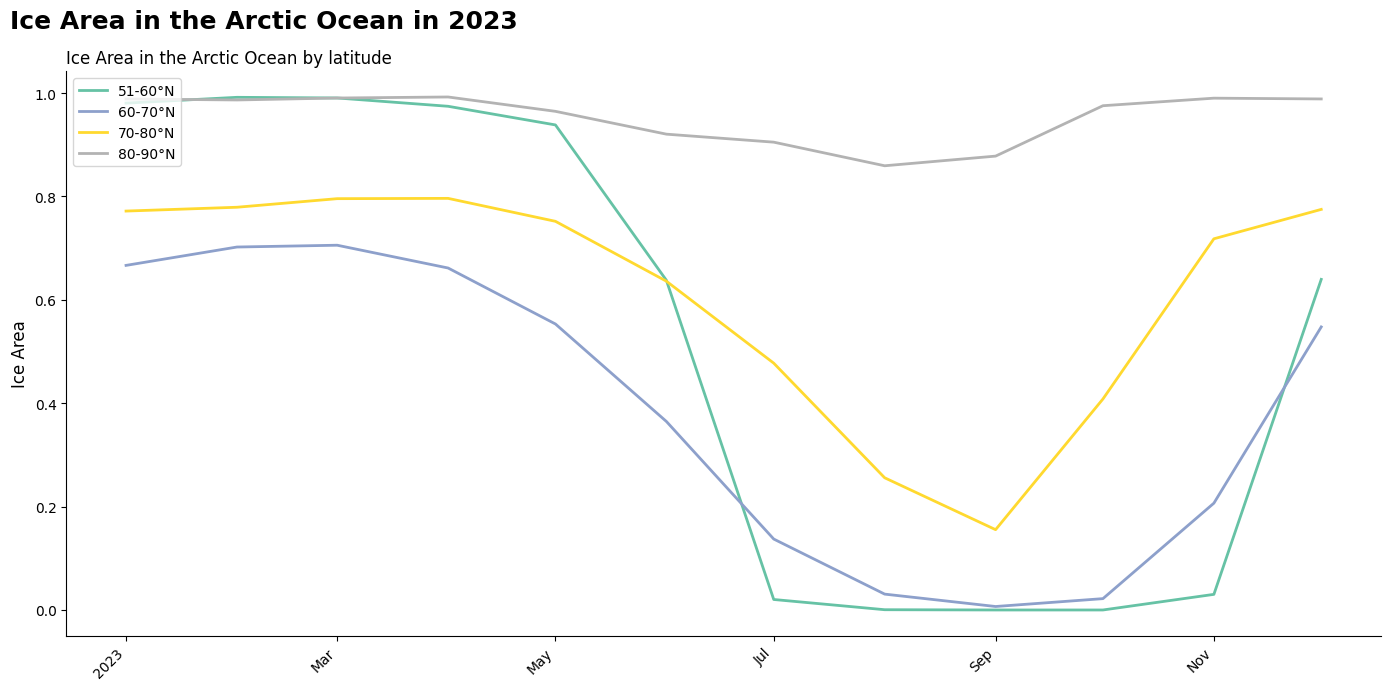

In [39]:
# Combine all dataframes from band_results
all_results = pd.concat(band_results)

# Create pivot table with time as index and lat_band as columns
pivot_data = all_results.pivot_table(index='time', columns='lat_band', values='siconc')

# Sort by time to ensure smooth plotting
pivot_data = pivot_data.sort_index()

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(14, 7))  # Define figure size

# Set up a colormap with as many colors as there are latitude bands
cmap = plt.get_cmap("Set2", len(pivot_data.columns))

# Plot each latitude band
for i, col in enumerate(pivot_data.columns):
    ax.plot(
        pivot_data.index,
        pivot_data[col],
        label=col,  # Format is already "X-Y°N"
        color=cmap(i),
        linewidth=2
    )

# --- Titles and labels ---
plt.suptitle(
    "Ice Area in the Arctic Ocean in 2023",
    fontsize=18, fontweight="bold", x=0.01, ha='left'
)
plt.title(
    "Ice Area in the Arctic Ocean by latitude",
    fontsize=12, loc='left'
)

# --- X-axis: auto-formatting for any time range ---
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for readability

# Add y-axis label
ax.set_ylabel("Ice Area", fontsize=12)

# --- Styling ---
ax.legend(title="", loc="upper left", fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

Ice area begins to declines in May and reaches its minimum in July. In the 70–90°N band, it starts refreezing in September, while in the 50–70°N band, minimal ice extent persists until November. Thus, the duration of minimal ice cover in the 50–70°N latitudes has increased from 2 to 4 months, with ice growth beginning in November but remaining limited through December.

# Exporting NetCDF Timesteps as GeoTIFFs

Define File Paths

In [44]:
# File paths
zarr_path = Path.cwd() / "data/" / "cmems_mod_arc_phy_my_nextsim_P1M-m_siconc_180.00W-179.97E_49.98N-90.03N_2023-01-01-2023-12-01.zarr"
output_dir = Path.cwd() / "data" / "rasters_2023"

# Ensure the output directory exists
output_dir.mkdir(parents=True, exist_ok=True)

# Load Zarr
ds = xr.open_zarr(zarr_path)

Inspect and Prepare the Zarr File

In [45]:
# Extract base name before the date range (e.g., 2023-01-01-2023-12-31)
match = re.match(r"^(.*)_\d{4}-\d{2}-\d{2}-\d{4}-\d{2}-\d{2}$", zarr_path.stem)
base_name = match.group(1) if match else zarr_path.stem

# Select only timesteps between January 1st and December 31st, 2023
ds = ds.sel(time=slice("2023-01-01", "2023-12-31"))

# Inspect the dataset
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (latitude: 1336, longitude: 12000, time: 12)
Coordinates:
  * latitude   (latitude) float64 11kB 49.98 50.01 50.04 ... 89.97 90.0 90.03
  * longitude  (longitude) float64 96kB -180.0 -180.0 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 96B 2023-01-01 2023-02-01 ... 2023-12-01
Data variables:
    siconc     (time, latitude, longitude) float64 2GB dask.array<chunksize=(1, 256, 2048), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    contact:                   servicedesk.cmems@mercator-ocean.eu
    copernicusmarine_version:  2.0.1
    credit:                    E.U. Copernicus Marine Service Information (CM...
    institution:               NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    references:                https://marine.copernicus.eu/
    source:                    neXtSIM model fields
    title:                     Arctic sea ice reanalysis

Loop Through Timesteps and Export Rasters

In [46]:
# Loop through timesteps
for i, timestamp in enumerate(ds["time"].values):
    da = ds["siconc"].sel(time=timestamp)
    date_str = pd.to_datetime(str(timestamp)).strftime("%Y-%m-%d")

    da.rio.write_crs("EPSG:4326", inplace=True)
    output_path = output_dir / f"{base_name}_{date_str}.tif"
    da.rio.to_raster(output_path)

In the next step, bring the rasters into QGIS to apply styling and visualize ice area fraction.
You can also automate the process using the provided Python script:
<a href="https://github.com/ElizavetK/Data-Portfolio/blob/main/Arctic%20Sea%20Ice%20Analysis/QGIS/layout_export.py">layout_export.py</a>